# Generative Adversarial Networks Project

#### For the course Complete Tensorflow 2 and Keras Deeplearning Bootcamp

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Data to be used
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

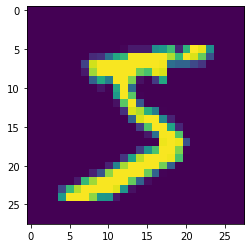

In [3]:
# Showing an image
plt.imshow(X_train[0]);

In [4]:
# How is the y_train
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

### Filtering out the Data for Faster Training on Smaller Dataset

We will use only the zeros for training.

In [5]:
only_zeros = X_train[y_train == 0]
only_zeros.shape # we have 5923 images of 28x28

(5923, 28, 28)

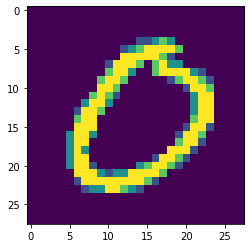

In [6]:
plt.imshow(only_zeros[555]);

## Creating the model

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 100

In [9]:
# Creation of the generator
generator = Sequential()

# dense layers
generator.add(Dense(100, activation="relu", input_shape=[codings_size]))
# 100 --> 150
generator.add(Dense(150, activation='relu'))
# 150 --> 784
generator.add(Dense(784, activation="sigmoid")) # 28*28 = 784

# reshape layer
generator.add(Reshape([28, 28])) # output => image ----- our discriminator expects this image

In [10]:
# Creation of the discriminator
discriminator = Sequential()

# Flatten the image 28*28 = 784
discriminator.add(Flatten(input_shape=[28,28]))
# 784 --> 150
discriminator.add(Dense(150, activation='relu'))
# 150 --> 100
discriminator.add(Dense(100, activation='relu'))
# 100 --> 1
discriminator.add(Dense(1, activation="sigmoid")) # output layer: is a valid image or not

# We compile the discriminator but not the generator
discriminator.compile(loss="binary_crossentropy", optimizer="adam")

In [11]:
# Creation of the GAN model
GAN = Sequential([generator, discriminator])

In [12]:
# We don't want to train 
discriminator.trainable = False 

# Compilation of GAN
GAN.compile(loss="binary_crossentropy", optimizer="adam")

In [13]:
GAN.layers

In [14]:
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28)            143634    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 132951    
                                                                 
Total params: 276,585
Trainable params: 143,634
Non-trainable params: 132,951
_________________________________________________________________


In [15]:
GAN.layers[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 150)               15150     
                                                                 
 dense_2 (Dense)             (None, 784)               118384    
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 143,634
Trainable params: 143,634
Non-trainable params: 0
_________________________________________________________________


In [16]:
GAN.layers[1].summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 150)               117750    
                                                                 
 dense_4 (Dense)             (None, 100)               15100     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 132,951
Trainable params: 0
Non-trainable params: 132,951
_________________________________________________________________


### Setting up Training Batches

In [17]:
import tensorflow as tf

batch_size = 32

dataset = tf.data.Dataset.from_tensor_slices(only_zeros).shuffle(buffer_size=1000)
type(dataset)

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

In [18]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

## Training the model

In [19]:
epochs = 6

# Separate components
generator, discriminator = GAN.layers

# For every epoch
for epoch in range(epochs):
    print(f"Epoch #{epoch + 1}")
    i = 0
    
    # For every batch in the dataset
    for X_batch in dataset:
        i = i + 1
        if i % 100 == 0:
            print(f"\t Currently on batch number {i} of {len(only_zeros) // batch_size}")

        ## TRAINING THE DISCRIMINATOR
        
        # Create noise
        # tf.random.normal -> outputs a tensor of the given shape filled with values of the dtype type from a normal distribution
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # Generate numbers based just on noise input
        gen_images = generator(noise)
        
        # Concatenate generated images against the real ones
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch, tf.float32)], axis=0)
        
        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
        
        discriminator.trainable = True    # this gets rid of a keras warning
        
        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        ## TRAINING THE GENERATOR 
        
        # Create some noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # We want discriminator to believe that fake images are real, so we give them value 1
        y2 = tf.constant([[1.]] * batch_size)
        
        # Avois a warning
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)
        
print("--- Complete ---")   

Epoch #1
	 Currently on batch number 100 of 185
Epoch #2
	 Currently on batch number 100 of 185
Epoch #3
	 Currently on batch number 100 of 185
Epoch #4
	 Currently on batch number 100 of 185
Epoch #5
	 Currently on batch number 100 of 185
Epoch #6
	 Currently on batch number 100 of 185
--- Complete ---


In [20]:
# Example of noise
noise = tf.random.normal(shape=[10, codings_size])
noise.shape

TensorShape([10, 100])

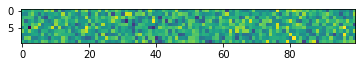

In [21]:
plt.imshow(noise);

In [22]:
images = generator(noise)
len(images)
len(images[5])

28

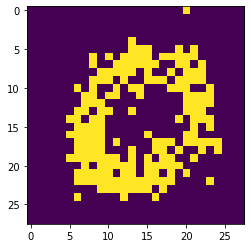

In [23]:
plt.imshow(images[5].numpy().reshape(28,28));

# Now let's use Convolutional Layers

In [24]:
# Data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [25]:
### Reshape and rescale images for DCGAN (Deep Convolutional GAN)

# Since our generator will use tanh activation function for the last layer, we want to reshape X_train to be between -1 and 1
# (as tanh function)

X_train = X_train / X_train.max()
X_train = X_train.reshape(-1, 28, 28, 1) * 2. - 1

In [26]:
X_train.min()

-1.0

In [27]:
X_train.max()

1.0

In [28]:
## Only zeros, again
only_zeros = X_train[y_train == 0]
only_zeros.shape

(5923, 28, 28, 1)

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Dropout, LeakyReLU, Flatten, BatchNormalization, Conv2D, Conv2DTranspose

# LeakyReLU behaves a little better that "relu" for convolutional gans

In [30]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 100

In [31]:
# Creating the generator
generator = Sequential()

generator.add(Dense(7 * 7 * 128, input_shape=[codings_size]))
generator.add(Reshape([7, 7, 128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="relu"))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh")) # one output because we need 1 image

In [32]:
# Creating the discriminator
discriminator = Sequential()

discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.3), input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid")) # One output : is a valid image or not

In [33]:
# Creation of GAN
GAN = Sequential([generator, discriminator])

In [34]:
# Compiling the discriminator
discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False

In [35]:
# Compiling the model
GAN.compile(loss="binary_crossentropy", optimizer="adam")

#### Training Batches

In [36]:
import tensorflow as tf

batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(only_zeros).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

#### Training loop

In [37]:
epochs = 20

# As separate components
generator, discriminator = GAN.layers

# For every epcoh
for epoch in range(epochs):
    print(f"Epoch #{epoch + 1}")

    i = 0
    # For every batch in the dataset
    for X_batch in dataset:
        i = i + 1
        if i % 20 == 0:
            print(f"\t On batch number {i} of {len(only_zeros) // batch_size}")

        ## TRAINING THE DISCRIMINATOR
        
        # Create noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # Generate numbers based just on noise input
        gen_images = generator(noise)
        
        # Concatenate generated images against the real ones
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)
        
        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
        
        discriminator.trainable = True  # this gets rid of a keras warning
        
        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        ## TRAINING THE GENERATOR 
        
        # Create some noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.]] * batch_size)
        
        # Avois a warning
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)
        
print("--- Complete ---")            

Epoch #1
	 On batch number 20 of 185
	 On batch number 40 of 185
	 On batch number 60 of 185
	 On batch number 80 of 185
	 On batch number 100 of 185
	 On batch number 120 of 185
	 On batch number 140 of 185
	 On batch number 160 of 185
	 On batch number 180 of 185
Epoch #2
	 On batch number 20 of 185
	 On batch number 40 of 185
	 On batch number 60 of 185
	 On batch number 80 of 185
	 On batch number 100 of 185
	 On batch number 120 of 185
	 On batch number 140 of 185
	 On batch number 160 of 185
	 On batch number 180 of 185
Epoch #3
	 On batch number 20 of 185
	 On batch number 40 of 185
	 On batch number 60 of 185
	 On batch number 80 of 185
	 On batch number 100 of 185
	 On batch number 120 of 185
	 On batch number 140 of 185
	 On batch number 160 of 185
	 On batch number 180 of 185
Epoch #4
	 On batch number 20 of 185
	 On batch number 40 of 185
	 On batch number 60 of 185
	 On batch number 80 of 185
	 On batch number 100 of 185
	 On batch number 120 of 185
	 On batch number 140 o

In [38]:
noise = tf.random.normal(shape=[10, codings_size])
noise.shape

TensorShape([10, 100])

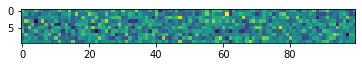

In [39]:
plt.imshow(noise)

In [40]:
images = generator(noise)

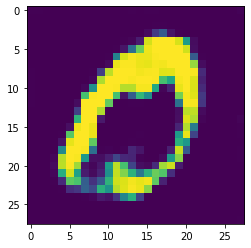

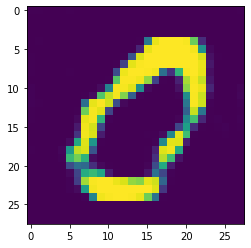

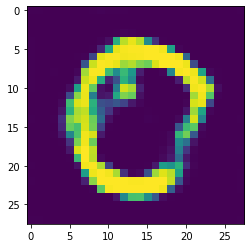

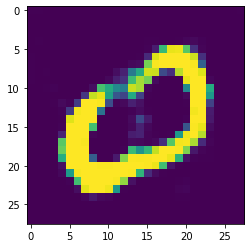

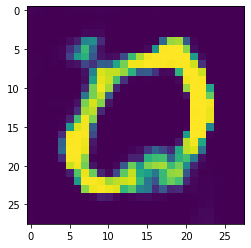

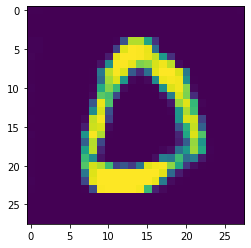

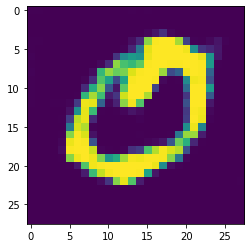

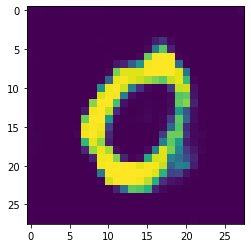

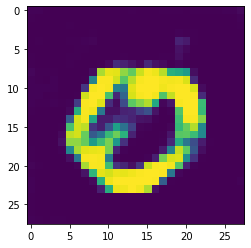

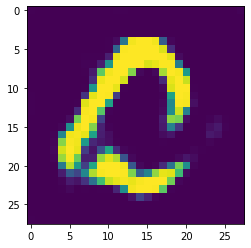

In [41]:
for image in images:
    plt.imshow(image.numpy().reshape(28,28))
    plt.show()